## Part ii Task 1, Ridgeless Function

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def ridgeless(train, test, d, threshold=1e-10):
    """
    Args:
        train: training data matrix
        test: test data matrix
        d: number of features (first d columns of feature data to use)
        threshold: threshold to use for filtering out singular values in SVD
    Returns:
        test_error
    """
    Y_train = train[:, 0]
    X_train = train[:, 1:d+1]

    Y_test = test[:, 0]
    X_test = test[:, 1:d+1]

    # center the features
    X_mean = np.mean(X_train, axis=0)
    X_train_centered = X_train - X_mean
    X_test_centered = X_test - X_mean

    # SVD decomposition
    U, S, Vt = np.linalg.svd(X_train_centered, full_matrices=False)

    S_inv = np.array([1/s if s > threshold else 0 for s in S]) # filter out small eigenvalues
    beta = Vt.T @ np.diag(S_inv) @ U.T @ Y_train

    Y_test_pred = X_test_centered @ beta
    test_error = np.mean((Y_test - Y_test_pred) ** 2)

    return test_error

## Part ii Task 2, Simulation Study

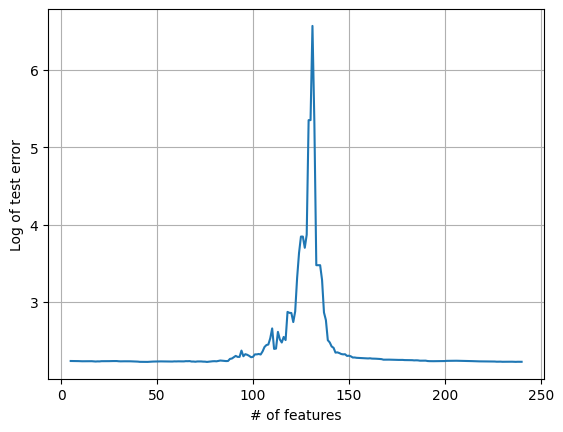

In [13]:
data = np.loadtxt('Coding3_dataH.csv', delimiter=',')


num_iterations = 30
n_samples, n_features = data.shape
num_d = 236
test_errors_matrix = np.zeros((num_iterations, num_d))

for i in range(num_iterations):
    np.random.shuffle(data)
    train_size = int(0.25 * n_samples)
    train_data = data[:train_size, :]
    test_data = data[train_size:, :]

    for d in range(6, 242):
        test_error = ridgeless(train_data, test_data, d)
        test_errors_matrix[i, d-6] = np.log(test_error)

median_test_errors = np.median(test_errors_matrix, axis=0)

plt.plot(range(5, 241), median_test_errors)
plt.xlabel('# of features')
plt.ylabel('Log of test error')
plt.grid(True)
plt.show()